# Mapping Inundation According to Flow Rates

### Background
Many of Australia's water bodies are regulated by humans. Flows are controlled by regulatory bodies such as the Murray Darling Basin Authority and local governments to meet the needs of water users while maintaining ecosystems dependant on the surface water. It is important that regulators know where the water goes when it goes overbank to help manage wetland inundations for environmental purposes and be informed of rural or residential areas likely to be flooded as a result of a large dam release. 

### The Problem 
Gauges have been placed along river systems all over Australia to monitor flow rates and water levels, however tracking where water goes when it spills over bank at a certain rate is challenging without combining the gauge data with satellite data.  

### Digital Earth Australia use case 
The Water Observations from Space (WOfS) dataset detects surface water in Australia based on Landsat data. By linking this dataset with gauge data, we can get information on where the water goes when it goes overbank according to flow rates measured by the gauge. Being able to see where water goes at different flow rates is valuable information for water regulators. 

### Description
In this example, we take gauge data and link it to WOfS data by date to create a summary image of water frequency according to a user-specified flow rate. 

## Getting Started
You will need to download a csv file from BoM's Water Data Online website and save it in an accessable location. 

### Load Packages
Here are the necessary imports required to generate graphs and work with data. 

In [1]:
#Just run this box once with 'Shift'+'Enter'. It loads all the things you need to work with the data. 
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
from matplotlib import pyplot
import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

# Enter location and generate duration curve

First, you have to get a csv file from http://www.bom.gov.au/waterdata/ 
Second, you have to save the csv file here in your sandbox. 
Thirdly, enter the location/name of your csv file in the box below where it says csv_file_location.
Lastly, press shift enter. A box will come up telling you what the lat and lon of the gauge is.

In [2]:
#Where abouts is your csv file located? It needs to be somewhere in your sandbox to run. 
csv_file_location = 'Boundary_Bend.csv'
pd.read_csv(csv_file_location, skiprows=1, nrows=2, escapechar='#')

,Station Number,414201
0,Station Location Latitude,-34.719669
1,Station Location Longitude,143.169863


Now, enter the lat and lon you want to look at. You can copy and paste the coordinates shown above. The buffer is the number of meters squared around the location. The code will now generate a flow duration curve. 

Text(0.5, 1.0, 'FDC')

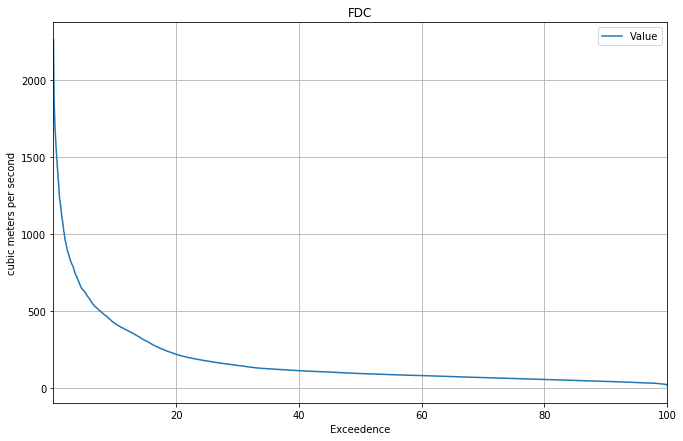

In [3]:
#What are the latitudes and longtitudes of the area you want to make a picture of?
lat = -34.71966901
lon = 143.1698626
buffer = 8000

#Loading and organising guage data
gauge_data = pd.read_csv(csv_file_location,
                error_bad_lines = False, skiprows=9, escapechar='#', 
                         parse_dates=['Timestamp'], #Tells it this column is date format
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0]))

#Rearranging data into a flow duration curve
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100
gauge_data = gauge_data.drop(columns='Interpolation Type')
gauge_data = gauge_data.drop(columns='Quality Code')


gauge_data.plot(x='Exceedence', y='Value', figsize=(11,7))
plt.ylabel('cubic meters per second')
plt.grid(True)
plt.title('FDC')

Here's the flow duration curve of the gauge data. Below, you can enter the part of the curve you are interested in looking at. 

# Select range of flow / water level to analyse

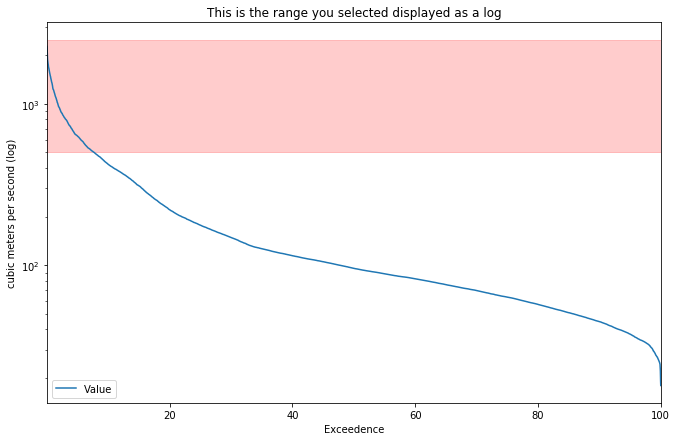

In [4]:
#What part of the Flow Duration Curve do you want to look at?
yaxis_lower_parameter = 500
yaxis_higher_parameter = 2500

#Let's look at it on a log scale
ax2 = gauge_data.plot(x='Exceedence', y='Value', figsize=(11,7)) 
ax2 = plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)
ax2 = plt.title('This is the range you selected displayed as a log')
ax2 = plt.ylabel('cubic meters per second (log)')
ax2 = plt.xlabel('Exceedence')
ax2 = pyplot.yscale('log')

Now the code will merge the satellite data (DEA's Water Observations from Space dataset) with the gauge data for the part of the duration curve you have selected. This part of the code will tell you how many satellite passes you are about to load (called 'time'). I recommend loading between 30 and 300 passes. If you got zero passes unexpectedly, check that you got the lower parameter and higher parameter around the right way. If you have too many passes, try narrowing the FDC parameters. The more passes you have, the longer it will take to run or you might get a memory error. Note: You might want to extended the query from August 2019, especially if there has been rain since then. 

In [5]:
gauge_data_xr = gauge_data.to_xarray()

#Dask loading wofs_albers data (loading parameters only, not loading the actual satellite data since 1988)
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1988-01-01', '2019-08-22'), # You might want to change the date to todays date
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)

# Merging satellite data with gauge data by timestamp
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time)

# Here is where it takes into account user input for the FDC
specified_level = merged_data.where((merged_data.Value > yaxis_lower_parameter) & 
                                    (merged_data.Value < yaxis_higher_parameter), drop=True)
date_list = specified_level.time.values

#Check how many satellite passes you are about to load
specified_level.time

<xarray.DataArray 'time' (time: 92)>
array(['1989-05-30T23:43:19.500000000', '1989-07-01T23:42:40.500000000',
       '1989-07-17T23:42:19.500000000', '1989-07-24T23:48:22.500000000',
       '1989-08-09T23:48:01.500000000', '1989-09-03T23:41:19.000000000',
       '1989-09-10T23:47:14.500000000', '1989-09-19T23:40:46.500000000',
       '1989-09-26T23:46:55.500000000', '1989-10-05T23:40:36.500000000',
       '1989-10-12T23:46:27.500000000', '1990-08-12T23:41:10.500000000',
       '1990-09-06T23:34:49.500000000', '1990-09-13T23:41:02.500000000',
       '1990-09-22T23:34:47.500000000', '1990-09-29T23:40:51.500000000',
       '1990-10-08T23:34:36.500000000', '1990-10-24T23:34:32.500000000',
       '1991-10-11T23:39:06.500000000', '1991-10-27T23:39:09.500000000',
       '1992-10-20T23:42:39.500000000', '1992-11-05T23:42:23.500000000',
       '1992-11-14T23:36:02.500000000', '1992-11-30T23:36:08.500000000',
       '1993-01-01T23:36:28.500000000', '1993-01-08T23:42:45.500000000',
       '1993-0

# Load data and cloud mask

The code will now load those passes above and cloud mask them; ie it will take out any passes that were too cloudy (this is done by using inbuilt modules from the Geoscience datacube that analyse bit flags). You can see how many clear passes you get after the cloud mask. I would suggest having at least 12 passes from which to generate a water frequency image. This step should take about 2mins to run if you have around 200 passes.  

In [6]:
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer), 
         'crs': 'EPSG:3577'} 

#loop selecting data based on FDC parameters
xr_list = []
for date in date_list:
    date = str(date)  
    wofs_albers= dc.load(product = 'wofs_albers', time=date,  **query)
    xr_list.append(wofs_albers)
specified_passes = xr.concat(xr_list, dim='time')

#Cloud Mask
ClearTimesteps = []
for ix, timestep in enumerate(specified_passes.time):
    SingleTime = specified_passes.water.isel(time=ix)
    IsItCloudy = masking.make_mask(SingleTime, cloud=True)
    CountClouds = IsItCloudy.sum()   
    PercentCloudy = CountClouds.values.item()/(len(specified_passes.x)*len(specified_passes*y))*100
    IsItClearEnough = PercentCloudy <= 50  
    if IsItClearEnough:
        ClearTimesteps.append(ix)     
clear_specified_passes = specified_passes.water.isel(time = ClearTimesteps)

wet = (clear_specified_passes == 128).sum(dim='time')
dry = (clear_specified_passes == 0).sum(dim='time')
clear = wet + dry
frequency = wet / clear
frequency= frequency.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency = frequency.where(frequency!=0) #This is to tell it to make areas that were dry 100% of the time white

#See how many clear passes you got to generate the image with
clear_specified_passes.time

<xarray.DataArray 'time' (time: 44)>
array(['1989-05-30T23:43:19.500000000', '1989-07-01T23:42:40.500000000',
       '1989-07-24T23:48:22.500000000', '1989-09-03T23:41:19.000000000',
       '1989-09-19T23:40:46.500000000', '1989-09-26T23:46:55.500000000',
       '1989-10-05T23:40:36.500000000', '1989-10-12T23:46:27.500000000',
       '1990-08-12T23:41:10.500000000', '1990-09-13T23:41:02.500000000',
       '1990-09-22T23:34:47.500000000', '1990-09-29T23:40:51.500000000',
       '1990-10-24T23:34:32.500000000', '1991-10-11T23:39:06.500000000',
       '1992-10-20T23:42:39.500000000', '1992-11-30T23:36:08.500000000',
       '1993-01-01T23:36:28.500000000', '1993-01-08T23:42:45.500000000',
       '1993-10-07T23:43:26.500000000', '1993-10-16T23:37:11.500000000',
       '1993-11-08T23:43:12.500000000', '1993-11-17T23:36:54.500000000',
       '1993-11-24T23:43:05.500000000', '1995-09-04T23:17:28.500000000',
       '1996-11-25T23:36:18.500000000', '1996-12-02T23:42:49.500000000',
       '2010-1

Here's the number of satellite passes you have after doing the cloud mask. An image will now be generated from the passes indicated above. 

# Generate image of specified flow / water level range

OK, here's the part where it generates an image of the lat and lon you entered according to the flow ranges you chose! The image will represent a summary of all the passes listed above, so you can see the frequency of inundation for that area. Yellow is high frequency and purple is low frequency. White means always dry.

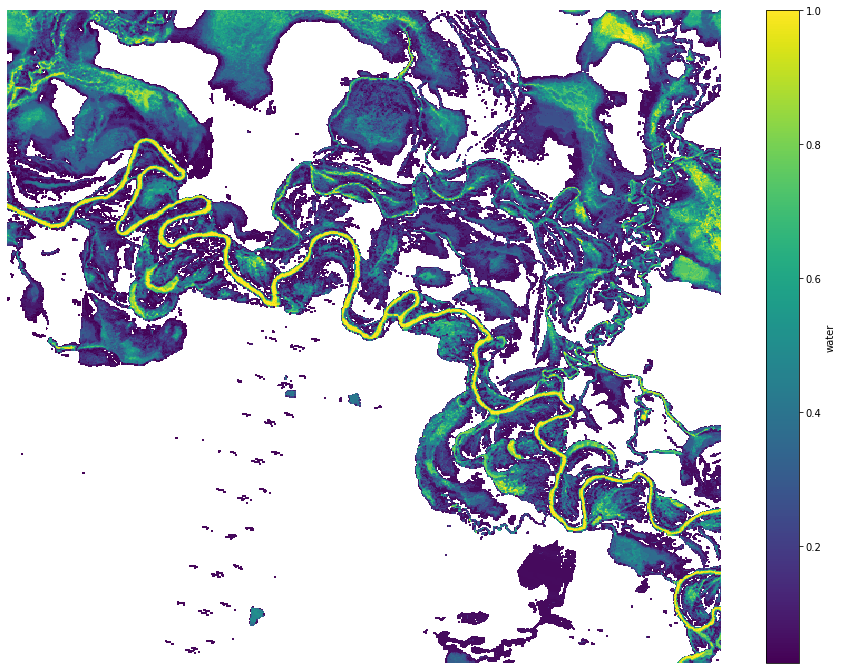

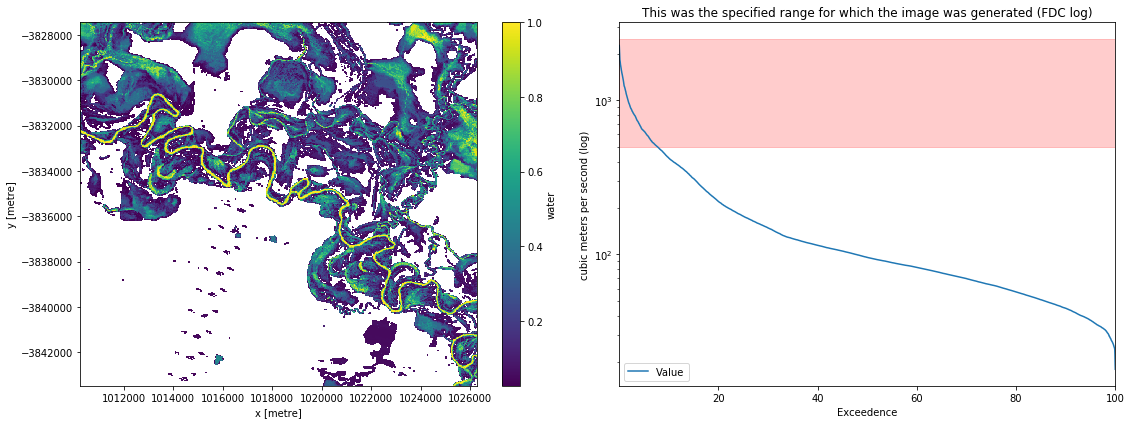

In [7]:
frequency.plot(figsize = (16, 12))
plt.axis('off')

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax1 = frequency.plot(ax=ax[0])

ax2 = gauge_data.plot(x='Exceedence', y='Value', ax=ax[1]) 
ax2 = plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)
ax2 = plt.title('This was the specified range for which the image was generated (FDC log)')
ax2 = plt.ylabel('cubic meters per second (log)')
ax2 = plt.xlabel('Exceedence')
ax2 = pyplot.yscale('log')

plt.tight_layout()

Nice! You can now go back and run the code again with different FDC parameters if you like, to see what this area looks like at another flow range. Take a screen shot of the image to save it to your computer. 